# ปีเตอร์กับหมาป่า: บทเรียนพื้นฐานเกี่ยวกับการเรียนรู้แบบเสริมกำลัง

ในบทเรียนนี้ เราจะเรียนรู้วิธีการนำการเรียนรู้แบบเสริมกำลังมาใช้กับปัญหาการค้นหาเส้นทาง สถานการณ์นี้ได้รับแรงบันดาลใจจากนิทานดนตรีเรื่อง [ปีเตอร์กับหมาป่า](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) โดยนักประพันธ์ชาวรัสเซีย [เซอร์เก โปรโกเฟียฟ](https://en.wikipedia.org/wiki/Sergei_Prokofiev) เป็นเรื่องราวเกี่ยวกับปีเตอร์ เด็กชายผู้กล้าหาญที่ออกจากบ้านไปยังลานป่าเพื่อไล่ล่าหมาป่า เราจะฝึกอัลกอริทึมการเรียนรู้ของเครื่องที่จะช่วยปีเตอร์สำรวจพื้นที่โดยรอบและสร้างแผนที่การนำทางที่เหมาะสมที่สุด

ก่อนอื่น มาเริ่มต้นด้วยการนำเข้าไลบรารีที่มีประโยชน์หลายตัว:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## ภาพรวมของการเรียนรู้แบบเสริมกำลัง

**การเรียนรู้แบบเสริมกำลัง** (Reinforcement Learning หรือ RL) เป็นเทคนิคการเรียนรู้ที่ช่วยให้เราสามารถเรียนรู้พฤติกรรมที่เหมาะสมที่สุดของ **ตัวแทน** (agent) ใน **สภาพแวดล้อม** (environment) โดยการทดลองทำซ้ำหลายๆ ครั้ง ตัวแทนในสภาพแวดล้อมนี้ควรมี **เป้าหมาย** ซึ่งกำหนดโดย **ฟังก์ชันรางวัล** (reward function)

## สภาพแวดล้อม

เพื่อความเข้าใจง่าย ลองพิจารณาโลกของปีเตอร์เป็นกระดานสี่เหลี่ยมขนาด `width` x `height` แต่ละช่องในกระดานนี้สามารถเป็นได้ดังนี้:
* **พื้นดิน** ซึ่งปีเตอร์และสิ่งมีชีวิตอื่นๆ สามารถเดินได้
* **น้ำ** ซึ่งแน่นอนว่าไม่สามารถเดินได้
* **ต้นไม้** หรือ **หญ้า** - สถานที่ที่คุณสามารถพักผ่อนได้
* **แอปเปิ้ล** ซึ่งเป็นสิ่งที่ปีเตอร์จะดีใจที่ได้พบเพื่อใช้เป็นอาหาร
* **หมาป่า** ซึ่งเป็นอันตรายและควรหลีกเลี่ยง

ในการทำงานกับสภาพแวดล้อม เราจะกำหนดคลาสที่เรียกว่า `Board` เพื่อไม่ให้เนื้อหาในสมุดบันทึกนี้ดูรกเกินไป เราได้ย้ายโค้ดทั้งหมดที่เกี่ยวข้องกับการทำงานของกระดานไปยังโมดูล `rlboard` แยกต่างหาก ซึ่งเราจะนำเข้าในตอนนี้ คุณสามารถดูรายละเอียดเพิ่มเติมเกี่ยวกับการทำงานภายในของการนำไปใช้ในโมดูลนี้ได้


In [2]:
from rlboard import *

ตอนนี้มาสร้างกระดานแบบสุ่มและดูว่ามันเป็นอย่างไร:


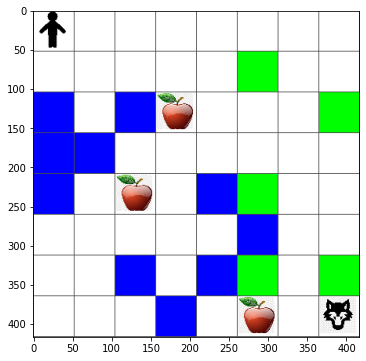

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## การกระทำและนโยบาย

ในตัวอย่างของเรา เป้าหมายของปีเตอร์คือการหาลูกแอปเปิ้ล ในขณะเดียวกันก็ต้องหลีกเลี่ยงหมาป่าและสิ่งกีดขวางอื่นๆ เพื่อทำสิ่งนี้ เขาสามารถเดินไปรอบๆ ได้จนกว่าจะเจอลูกแอปเปิ้ล ดังนั้น ในแต่ละตำแหน่ง เขาสามารถเลือกทำหนึ่งในสี่การกระทำต่อไปนี้: ขึ้น, ลง, ซ้าย และขวา เราจะกำหนดการกระทำเหล่านี้เป็นพจนานุกรม และจับคู่กับการเปลี่ยนแปลงพิกัดที่สอดคล้องกัน ตัวอย่างเช่น การเคลื่อนที่ไปทางขวา (`R`) จะสอดคล้องกับคู่พิกัด `(1,0)`


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

กลยุทธ์ของตัวแทนของเรา (ปีเตอร์) ถูกกำหนดโดยสิ่งที่เรียกว่า **นโยบาย** ลองพิจารณานโยบายที่ง่ายที่สุดที่เรียกว่า **การเดินแบบสุ่ม**

## การเดินแบบสุ่ม

มาแก้ปัญหาของเราด้วยการใช้กลยุทธ์การเดินแบบสุ่ม


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

มาลองทำการทดลองเดินสุ่มหลายครั้งและดูจำนวนก้าวเฉลี่ยที่ใช้:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## ฟังก์ชันรางวัล

เพื่อทำให้กลยุทธ์ของเราฉลาดขึ้น เราจำเป็นต้องเข้าใจว่าการเคลื่อนไหวใด "ดีกว่า" การเคลื่อนไหวอื่นๆ


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

สร้าง Q-Table หรืออาร์เรย์หลายมิติ เนื่องจากกระดานของเรามีขนาด `width` x `height` เราสามารถแสดง Q-Table ด้วย numpy array ที่มีรูปร่าง `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

ส่ง Q-Table ไปยังฟังก์ชัน plot เพื่อแสดงตารางบนกระดาน:


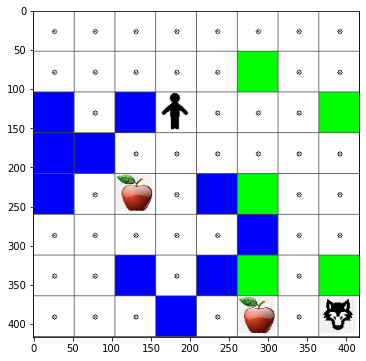

In [9]:
m.plot(Q)

## สาระสำคัญของ Q-Learning: สมการ Bellman และอัลกอริทึมการเรียนรู้

เขียน pseudo-code สำหรับอัลกอริทึมการเรียนรู้ของเรา:

* เริ่มต้น Q-Table Q ด้วยค่าที่เท่ากันสำหรับทุกสถานะและการกระทำ
* กำหนดอัตราการเรียนรู้ $\alpha\leftarrow 1$
* ทำการจำลองซ้ำหลายครั้ง
   1. เริ่มต้นที่ตำแหน่งสุ่ม
   1. ทำซ้ำ
        1. เลือกการกระทำ $a$ ที่สถานะ $s$
        2. ดำเนินการโดยย้ายไปยังสถานะใหม่ $s'$
        3. หากพบเงื่อนไขสิ้นสุดเกม หรือรางวัลรวมมีค่าน้อยเกินไป - ออกจากการจำลอง  
        4. คำนวณรางวัล $r$ ที่สถานะใหม่
        5. อัปเดต Q-Function ตามสมการ Bellman: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. อัปเดตรางวัลรวมและลดค่า $\alpha$

## ใช้ประโยชน์ vs. สำรวจ

วิธีที่ดีที่สุดคือการสร้างสมดุลระหว่างการสำรวจและการใช้ประโยชน์ เมื่อเราเรียนรู้เกี่ยวกับสภาพแวดล้อมมากขึ้น เราจะมีแนวโน้มที่จะเลือกเส้นทางที่เหมาะสมที่สุด แต่ควรเลือกเส้นทางที่ยังไม่ได้สำรวจเป็นครั้งคราว

## การใช้งาน Python

ตอนนี้เราพร้อมที่จะใช้อัลกอริทึมการเรียนรู้ ก่อนหน้านั้น เราต้องมีฟังก์ชันที่จะแปลงตัวเลขใน Q-Table ให้เป็นเวกเตอร์ของความน่าจะเป็นสำหรับการกระทำที่เกี่ยวข้อง:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

เราเพิ่มค่า `eps` เล็กน้อยลงในเวกเตอร์ต้นฉบับเพื่อหลีกเลี่ยงการหารด้วย 0 ในกรณีเริ่มต้น เมื่อทุกองค์ประกอบของเวกเตอร์มีค่าเหมือนกัน

อัลกอริทึมการเรียนรู้ที่เราจะใช้งานจริงสำหรับการทดลอง 5000 ครั้ง ซึ่งเรียกว่า **epochs**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

หลังจากดำเนินการอัลกอริทึมนี้ ตาราง Q-Table ควรได้รับการอัปเดตด้วยค่าที่กำหนดความน่าสนใจของการกระทำต่าง ๆ ในแต่ละขั้นตอน แสดงตารางที่นี่:


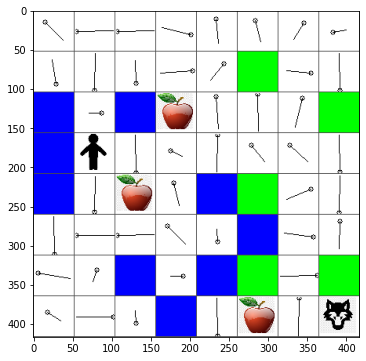

In [12]:
m.plot(Q)

## การตรวจสอบนโยบาย

เนื่องจาก Q-Table แสดง "ความน่าสนใจ" ของแต่ละการกระทำในแต่ละสถานะ การใช้งานเพื่อกำหนดการนำทางที่มีประสิทธิภาพในโลกของเราจึงค่อนข้างง่าย ในกรณีที่ง่ายที่สุด เราสามารถเลือกการกระทำที่สอดคล้องกับค่าที่สูงที่สุดใน Q-Table ได้:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

หากคุณลองรันโค้ดด้านบนหลายครั้ง คุณอาจสังเกตเห็นว่าบางครั้งมันจะ "ค้าง" และคุณจำเป็นต้องกดปุ่ม STOP ในโน้ตบุ๊กเพื่อหยุดการทำงาน

> **งานที่ 1:** แก้ไขฟังก์ชัน `walk` เพื่อจำกัดความยาวสูงสุดของเส้นทางโดยกำหนดจำนวนก้าว (เช่น 100) และดูว่าโค้ดด้านบนคืนค่านี้เป็นครั้งคราว

> **งานที่ 2:** แก้ไขฟังก์ชัน `walk` เพื่อไม่ให้กลับไปยังตำแหน่งที่เคยไปมาก่อนหน้านี้ สิ่งนี้จะช่วยป้องกันไม่ให้ `walk` วนลูป อย่างไรก็ตาม ตัวแทนอาจยังคงติดอยู่ในตำแหน่งที่ไม่สามารถหลบหนีได้


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


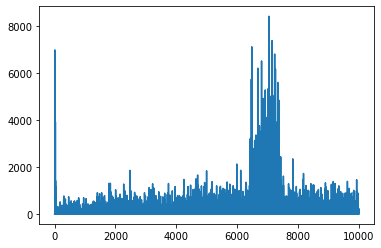

In [15]:
plt.plot(lpath)

สิ่งที่เราเห็นในที่นี้คือในตอนแรกความยาวเฉลี่ยของเส้นทางเพิ่มขึ้น นี่อาจเป็นเพราะว่าเมื่อเราไม่รู้อะไรเกี่ยวกับสภาพแวดล้อมเลย เรามักจะติดอยู่ในสถานะที่ไม่ดี เช่น น้ำหรือหมาป่า เมื่อเราเรียนรู้มากขึ้นและเริ่มใช้ความรู้นี้ เราสามารถสำรวจสภาพแวดล้อมได้นานขึ้น แต่เรายังไม่รู้แน่ชัดว่าแอปเปิ้ลอยู่ที่ไหน

เมื่อเราเรียนรู้มากพอ มันจะง่ายขึ้นสำหรับตัวแทนในการบรรลุเป้าหมาย และความยาวของเส้นทางก็เริ่มลดลง อย่างไรก็ตาม เรายังคงเปิดรับการสำรวจ ดังนั้นเรามักจะเบี่ยงเบนออกจากเส้นทางที่ดีที่สุด และลองสำรวจตัวเลือกใหม่ ๆ ซึ่งทำให้เส้นทางยาวกว่าที่ควรจะเป็น

สิ่งที่เราสังเกตได้อีกอย่างจากกราฟนี้คือในบางจุดความยาวเพิ่มขึ้นอย่างรวดเร็ว สิ่งนี้บ่งชี้ถึงธรรมชาติแบบสุ่มของกระบวนการ และในบางครั้งเราอาจ "ทำให้ค่าสัมประสิทธิ์ใน Q-Table เสียหาย" โดยการเขียนทับด้วยค่าที่ใหม่กว่า ซึ่งควรลดผลกระทบนี้ให้น้อยที่สุดโดยการลดอัตราการเรียนรู้ (เช่น ในช่วงท้ายของการฝึก เราปรับค่าของ Q-Table เพียงเล็กน้อย)

โดยรวมแล้ว สิ่งสำคัญคือต้องจำไว้ว่าความสำเร็จและคุณภาพของกระบวนการเรียนรู้ขึ้นอยู่กับพารามิเตอร์อย่างมาก เช่น อัตราการเรียนรู้ การลดอัตราการเรียนรู้ และตัวคูณลดค่า พารามิเตอร์เหล่านี้มักถูกเรียกว่า **ไฮเปอร์พารามิเตอร์** เพื่อแยกความแตกต่างจาก **พารามิเตอร์** ซึ่งเราปรับแต่งระหว่างการฝึก (เช่น ค่าสัมประสิทธิ์ใน Q-Table) กระบวนการค้นหาค่าที่ดีที่สุดของไฮเปอร์พารามิเตอร์เรียกว่า **การปรับแต่งไฮเปอร์พารามิเตอร์** ซึ่งเป็นหัวข้อที่ควรศึกษาแยกต่างหาก


## แบบฝึกหัด
#### โลกของปีเตอร์กับหมาป่าที่สมจริงยิ่งขึ้น

ในสถานการณ์ของเรา ปีเตอร์สามารถเคลื่อนที่ไปมาได้แทบจะไม่รู้สึกเหนื่อยหรือหิวเลย ในโลกที่สมจริงมากขึ้น เขาจะต้องนั่งพักเป็นครั้งคราว และต้องหาอาหารกินด้วย ลองทำให้โลกของเราสมจริงขึ้นโดยการเพิ่มกฎดังต่อไปนี้:

1. เมื่อปีเตอร์เคลื่อนที่จากที่หนึ่งไปยังอีกที่หนึ่ง เขาจะสูญเสีย **พลังงาน** และเพิ่ม **ความเหนื่อยล้า** ขึ้น
2. ปีเตอร์สามารถเพิ่มพลังงานได้โดยการกินแอปเปิ้ล
3. ปีเตอร์สามารถลดความเหนื่อยล้าได้โดยการพักผ่อนใต้ต้นไม้หรือบนพื้นหญ้า (เช่น เดินไปยังตำแหน่งบนกระดานที่มีต้นไม้หรือหญ้า - พื้นที่สีเขียว)
4. ปีเตอร์ต้องค้นหาและฆ่าหมาป่า
5. เพื่อที่จะฆ่าหมาป่า ปีเตอร์จำเป็นต้องมีระดับพลังงานและความเหนื่อยล้าในระดับที่เหมาะสม มิฉะนั้นเขาจะพ่ายแพ้ในการต่อสู้

ปรับฟังก์ชันรางวัลตามกฎของเกมนี้ จากนั้นรันอัลกอริทึมการเรียนรู้แบบเสริมกำลังเพื่อเรียนรู้กลยุทธ์ที่ดีที่สุดในการชนะเกม และเปรียบเทียบผลลัพธ์ของการเดินแบบสุ่มกับอัลกอริทึมของคุณในแง่ของจำนวนเกมที่ชนะและแพ้

> **Note**: คุณอาจต้องปรับไฮเปอร์พารามิเตอร์เพื่อให้ระบบทำงานได้ โดยเฉพาะจำนวนรอบการฝึกฝน เนื่องจากความสำเร็จของเกม (การต่อสู้กับหมาป่า) เป็นเหตุการณ์ที่เกิดขึ้นได้ยาก คุณอาจต้องใช้เวลาฝึกฝนนานขึ้น



---

**ข้อจำกัดความรับผิดชอบ**:  
เอกสารนี้ได้รับการแปลโดยใช้บริการแปลภาษา AI [Co-op Translator](https://github.com/Azure/co-op-translator) แม้ว่าเราจะพยายามให้การแปลมีความถูกต้อง แต่โปรดทราบว่าการแปลโดยอัตโนมัติอาจมีข้อผิดพลาดหรือความไม่ถูกต้อง เอกสารต้นฉบับในภาษาดั้งเดิมควรถือเป็นแหล่งข้อมูลที่เชื่อถือได้ สำหรับข้อมูลที่สำคัญ ขอแนะนำให้ใช้บริการแปลภาษามืออาชีพ เราไม่รับผิดชอบต่อความเข้าใจผิดหรือการตีความผิดที่เกิดจากการใช้การแปลนี้
